In [9]:
import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
pip install memory_profiler;


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
pip install line_profiler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
data = pd.read_csv('drive/My Drive/abcnews-date-text.csv', error_bad_lines=False);
data_text = data[['headline_text']];

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
data_text.shape
data_trimmed=data_text.iloc[:10000,:]

In [16]:
data_text = data_trimmed.astype('str');
for idx in range(len(data_text)):
    
    #go through each word in each data_text row, remove stopwords, and set them on the index.
    data_text.iloc[idx]['headline_text'] = [word for word in data_text.iloc[idx]['headline_text'].split(' ') if word not in stopwords.words()];
    
    #print logs to monitor output
    if idx % 1000 == 0:
        sys.stdout.write('\rc = ' + str(idx) + ' / ' + str(len(data_text)));
#save data because it takes very long to remove stop words
pickle.dump(data_text, open('data_text.dat', 'wb'))
#get the words as an array for lda input
train_headlines = [value[0] for value in data_text.iloc[0:].values]

c = 9000 / 10000

In [17]:
num_topics = 10;

id2word = gensim.corpora.Dictionary(train_headlines);
corpus = [id2word.doc2bow(text) for text in train_headlines];
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics);

In [50]:
import resource
import tracemalloc
def get_lda_topics(model, num_topics):
    word_dict = {};
    usertime=[]
    memory=[]

    tracemalloc.start()
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
        usage=resource.getrusage(resource.RUSAGE_SELF)
        usertime.append(usage[1])
        memory.append(tracemalloc.get_traced_memory()[0] )
    tracemalloc.stop()
    return usertime, memory, pd.DataFrame(word_dict);

In [21]:
%memit  get_lda_topics(lda, num_topics)

peak memory: 420.68 MiB, increment: 2.01 MiB


In [28]:
import resource
def using(point=""):
    usage=resource.getrusage(resource.RUSAGE_THREAD)
    print(usage)
    return '''%s: usertime=%s systime=%s mem=%s mb
           '''%(point,usage[0],usage[1],
                usage[2]/1024.0 )

In [29]:
import gc

gc.collect()

print(using("before"))
wrk = ["wasting mem"] * 1000000
print(using("after"))

resource.struct_rusage(ru_utime=320.725721, ru_stime=43.123539, ru_maxrss=444132, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=7940291, ru_majflt=482, ru_nswap=0, ru_inblock=117440, ru_oublock=2056, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=59285, ru_nivcsw=66365)
before: usertime=320.725721 systime=43.123539 mem=433.72265625 mb
           
resource.struct_rusage(ru_utime=320.730785, ru_stime=43.123547, ru_maxrss=444132, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=7940292, ru_majflt=482, ru_nswap=0, ru_inblock=117440, ru_oublock=2056, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=59300, ru_nivcsw=66371)
after: usertime=320.730785 systime=43.123547 mem=433.72265625 mb
           


[44.791012, 44.791012, 44.791012, 44.791032, 44.791032, 44.791032, 44.791044, 44.791735, 44.791975, 44.791975]
[1399, 1718, 2005, 2292, 2611, 3226, 3513, 3800, 4151, 4502]


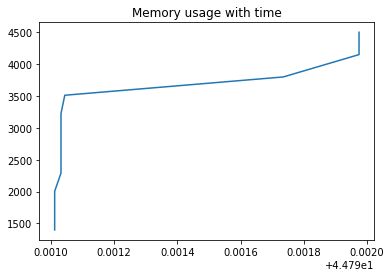

In [51]:
from matplotlib import pyplot as plt 

usage, memory, pddf = get_lda_topics(lda, num_topics)

plt.title("Memory usage with time")
print(usage)
print(memory)
# Plot values using x,y coordinates:
plt.plot(usage,memory)
plt.show()